In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 831)
(734160, 1)
validation
(101248, 831)
(101248, 1)
test
(100432, 831)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:53 - loss: 0.0815 - STD: 1.5417e-04 - MAE: 0.2747

 4/74 [>.............................] - ETA: 1s - loss: 0.0349 - STD: 3.1407e-04 - MAE: 0.1432  

 7/74 [=>............................] - ETA: 1s - loss: 0.0331 - STD: 2.6031e-04 - MAE: 0.1407

10/74 [===>..........................] - ETA: 1s - loss: 0.0300 - STD: 2.6167e-04 - MAE: 0.1303

13/74 [====>.........................] - ETA: 1s - loss: 0.0263 - STD: 2.9773e-04 - MAE: 0.1159

16/74 [=====>........................] - ETA: 1s - loss: 0.0243 - STD: 3.3731e-04 - MAE: 0.1141

19/74 [======>.......................] - ETA: 1s - loss: 0.0230 - STD: 3.7160e-04 - MAE: 0.1135

22/74 [=======>......................] - ETA: 1s - loss: 0.0215 - STD: 3.9905e-04 - MAE: 0.1085

25/74 [=========>....................] - ETA: 1s - loss: 0.0204 - STD: 4.2040e-04 - MAE: 0.1027

28/74 [==========>...................] - ETA: 1s - loss: 0.0198 - STD: 4.4147e-04 - MAE: 0.0983

31/74 [===========>..................] - ETA: 1s - loss: 0.0191 - STD: 4.6762e-04 - MAE: 0.0947

33/74 [============>.................] - ETA: 0s - loss: 0.0187 - STD: 4.8990e-04 - MAE: 0.0930

36/74 [=============>................] - ETA: 0s - loss: 0.0181 - STD: 5.2839e-04 - MAE: 0.0918

39/74 [==============>...............] - ETA: 0s - loss: 0.0177 - STD: 5.7187e-04 - MAE: 0.0911

42/74 [================>.............] - ETA: 0s - loss: 0.0172 - STD: 6.1820e-04 - MAE: 0.0899

45/74 [=================>............] - ETA: 0s - loss: 0.0169 - STD: 6.6653e-04 - MAE: 0.0882

48/74 [==================>...........] - ETA: 0s - loss: 0.0165 - STD: 7.2051e-04 - MAE: 0.0865

51/74 [===================>..........] - ETA: 0s - loss: 0.0162 - STD: 7.8546e-04 - MAE: 0.0851

54/74 [====================>.........] - ETA: 0s - loss: 0.0160 - STD: 8.6491e-04 - MAE: 0.0841

57/74 [======================>.......] - ETA: 0s - loss: 0.0157 - STD: 9.6011e-04 - MAE: 0.0835

60/74 [=======================>......] - ETA: 0s - loss: 0.0155 - STD: 0.0011 - MAE: 0.0829    

63/74 [========================>.....] - ETA: 0s - loss: 0.0153 - STD: 0.0012 - MAE: 0.0822

66/74 [=========================>....] - ETA: 0s - loss: 0.0152 - STD: 0.0014 - MAE: 0.0813

69/74 [==========================>...] - ETA: 0s - loss: 0.0150 - STD: 0.0016 - MAE: 0.0806

71/74 [===========================>..] - ETA: 0s - loss: 0.0149 - STD: 0.0017 - MAE: 0.0802

74/74 [==============================] - ETA: 0s - loss: 0.0147 - STD: 0.0020 - MAE: 0.0796

74/74 [==============================] - 5s 43ms/step - loss: 0.0147 - STD: 0.0020 - MAE: 0.0796 - val_loss: 0.0126 - val_STD: 0.0072 - val_MAE: 0.0696


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0106 - STD: 0.0107 - MAE: 0.0661

 4/74 [>.............................] - ETA: 1s - loss: 0.0104 - STD: 0.0123 - MAE: 0.0653

 7/74 [=>............................] - ETA: 1s - loss: 0.0101 - STD: 0.0141 - MAE: 0.0635

10/74 [===>..........................] - ETA: 1s - loss: 0.0097 - STD: 0.0163 - MAE: 0.0617

13/74 [====>.........................] - ETA: 1s - loss: 0.0094 - STD: 0.0191 - MAE: 0.0603

16/74 [=====>........................] - ETA: 1s - loss: 0.0090 - STD: 0.0224 - MAE: 0.0588

19/74 [======>.......................] - ETA: 1s - loss: 0.0085 - STD: 0.0262 - MAE: 0.0571

22/74 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0303 - MAE: 0.0553

25/74 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.0347 - MAE: 0.0538

28/74 [==========>...................] - ETA: 1s - loss: 0.0073 - STD: 0.0389 - MAE: 0.0522

31/74 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0429 - MAE: 0.0508

34/74 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0465 - MAE: 0.0495

37/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0499 - MAE: 0.0484

40/74 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0529 - MAE: 0.0474

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0557 - MAE: 0.0465

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0581 - MAE: 0.0457

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0603 - MAE: 0.0450

52/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0444

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0438

58/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0655 - MAE: 0.0433

61/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0414

74/74 [==============================] - 2s 26ms/step - loss: 0.0045 - STD: 0.0718 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0735 - val_MAE: 0.0340


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0335

 3/74 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.0953 - MAE: 0.0333

 5/74 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.0955 - MAE: 0.0333

 8/74 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0334

11/74 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0334

14/74 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0333

17/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0332

20/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0332

23/74 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0332

26/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

29/74 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

32/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

35/74 [=============>................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

38/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0329

41/74 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0328

44/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328

47/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328

50/74 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

53/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

56/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0326

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0326

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0325

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0325

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0325

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0324

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0969 - MAE: 0.0324

74/74 [==============================] - 2s 26ms/step - loss: 0.0024 - STD: 0.0969 - MAE: 0.0324 - val_loss: 0.0025 - val_STD: 0.0751 - val_MAE: 0.0325


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0319

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

 7/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

10/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0315

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0315

16/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

22/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0312

28/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

34/74 [============>.................] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

40/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0310

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0310

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0309

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0309

74/74 [==============================] - 2s 26ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0309 - val_loss: 0.0023 - val_STD: 0.0766 - val_MAE: 0.0313


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0305

 3/74 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0306

 5/74 [=>............................] - ETA: 1s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

 8/74 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0305

10/74 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305

13/74 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

16/74 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0304

19/74 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0303

22/74 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0303

25/74 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0303

28/74 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0303

31/74 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0302

34/74 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0302

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0302

40/74 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0302

46/74 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0302

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

52/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

55/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0302

58/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0301

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0301

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0300

74/74 [==============================] - 2s 27ms/step - loss: 0.0020 - STD: 0.0993 - MAE: 0.0300 - val_loss: 0.0022 - val_STD: 0.0775 - val_MAE: 0.0311


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0978 - MAE: 0.0289

 4/74 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.0986 - MAE: 0.0291

 7/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

10/74 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

13/74 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0294

16/74 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

19/74 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

22/74 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

25/74 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0296

28/74 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0296

31/74 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

34/74 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0297

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0296

40/74 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0296

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0296

46/74 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0296

52/74 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0296

55/74 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0296

58/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0295

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0295

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0295

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

74/74 [==============================] - 2s 27ms/step - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294 - val_loss: 0.0021 - val_STD: 0.0779 - val_MAE: 0.0298


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0294

 4/74 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0289

 7/74 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

10/74 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

13/74 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

16/74 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

19/74 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0288

25/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0288

28/74 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

34/74 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

37/74 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0290

40/74 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

46/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

49/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0289

55/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288

74/74 [==============================] - 2s 26ms/step - loss: 0.0018 - STD: 0.1003 - MAE: 0.0288 - val_loss: 0.0020 - val_STD: 0.0784 - val_MAE: 0.0295


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0284

 4/74 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0286

 7/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0286

10/74 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

13/74 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

16/74 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0286

19/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

22/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

25/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

28/74 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

31/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

34/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

37/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

40/74 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

43/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

46/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

49/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0287

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

55/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

58/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

74/74 [==============================] - 2s 26ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.0787 - val_MAE: 0.0298


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0987 - MAE: 0.0281

 3/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

 6/74 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

12/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0280

18/74 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0281

21/74 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

24/74 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0282

27/74 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0285

30/74 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0288

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0289

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0289

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0289

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0290

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0291

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0292

57/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0291

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0291

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289

74/74 [==============================] - 2s 26ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289 - val_loss: 0.0020 - val_STD: 0.0784 - val_MAE: 0.0291


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0276

 3/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

 6/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

12/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

15/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

18/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

21/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

24/74 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

27/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

30/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

33/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

36/74 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

47/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

50/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

52/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

54/74 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

56/74 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

74/74 [==============================] - 2s 27ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282 - val_loss: 0.0020 - val_STD: 0.0807 - val_MAE: 0.0301


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0274

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0274

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0274

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

31/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

74/74 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0794 - val_MAE: 0.0289


Epoch 12/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0272

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0276

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0279

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

31/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

74/74 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0795 - val_MAE: 0.0287


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0274

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0274

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

43/74 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

46/74 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

49/74 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

52/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

55/74 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

58/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

74/74 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277 - val_loss: 0.0019 - val_STD: 0.0792 - val_MAE: 0.0283


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0995 - MAE: 0.0271

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0273

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

16/74 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

19/74 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

22/74 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

25/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

34/74 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

37/74 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

40/74 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0274 - val_loss: 0.0019 - val_STD: 0.0815 - val_MAE: 0.0299


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0278

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0276

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0275

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0275

13/74 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0273

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0272

31/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0272

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0273

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273 - val_loss: 0.0020 - val_STD: 0.0777 - val_MAE: 0.0289


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0992 - MAE: 0.0290

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

11/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

30/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0274

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273 - val_loss: 0.0019 - val_STD: 0.0815 - val_MAE: 0.0302


Epoch 17/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1026 - MAE: 0.0280

 3/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0281

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0274

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

30/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

39/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

42/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

45/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

48/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

51/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

54/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

57/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0788 - val_MAE: 0.0281


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0267

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0268

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0268

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0270

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0269

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0273

74/74 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0281


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1000 - MAE: 0.0267

 6/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

12/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

27/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

30/74 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

33/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

36/74 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

38/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0269

41/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

44/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

47/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

50/74 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

53/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

56/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268 - val_loss: 0.0020 - val_STD: 0.0824 - val_MAE: 0.0308


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0270

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0277

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0277

28/74 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

31/74 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0276

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0276

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0275

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0273

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0786 - val_MAE: 0.0279


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1015 - MAE: 0.0259

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0266

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0266

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0265

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0265

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0267

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

74/74 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0797 - val_MAE: 0.0281


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0258

 3/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.0995 - MAE: 0.0258

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1005 - MAE: 0.0260

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0263

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0264

15/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0267

18/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0267

27/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

30/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

33/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

35/74 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

38/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

44/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

47/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

50/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

53/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

56/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

74/74 [==============================] - 2s 26ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0825 - val_MAE: 0.0300


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0274

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0272

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0271

10/74 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0268

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0267

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0266

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

43/74 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

46/74 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

49/74 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

52/74 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

55/74 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

58/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280

74/74 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1017 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0744 - val_MAE: 0.0279


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0972 - MAE: 0.0272

 4/74 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

 7/74 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0276

10/74 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0274

13/74 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1002 - MAE: 0.0273

16/74 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0271

19/74 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1006 - MAE: 0.0270

22/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0269

25/74 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0268

28/74 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0268

31/74 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0267

34/74 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0267

37/74 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0266

40/74 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0266

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0265

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0265

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0265

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0265

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

74/74 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0765 - val_MAE: 0.0282


Epoch 25/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0960 - MAE: 0.0275

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0268

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265

74/74 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1021 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0795 - val_MAE: 0.0277


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0264

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0260

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0262

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

42/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

45/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0261

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

54/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

57/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

74/74 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0799 - val_MAE: 0.0277


Epoch 27/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

 3/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0257

 6/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0261

 9/74 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0262

12/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0262

15/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0267

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0269

21/74 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0273

24/74 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1029 - MAE: 0.0277

27/74 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0281

30/74 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0288

33/74 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0294

36/74 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0293

39/74 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0293

42/74 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0292

45/74 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0292

48/74 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0290

51/74 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

54/74 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0287

57/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0281

74/74 [==============================] - 2s 26ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0280 - val_loss: 0.0018 - val_STD: 0.0807 - val_MAE: 0.0285


Epoch 28/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0257

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0259

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0257

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0259

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0258

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0258

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0259

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0259

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0259

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0258

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0259

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0258

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

42/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

45/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

57/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0258

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259 - val_loss: 0.0018 - val_STD: 0.0804 - val_MAE: 0.0277


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0262

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0264

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0262

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

74/74 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0817 - val_MAE: 0.0294


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0263

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0264

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0264

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

40/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

49/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

52/74 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

55/74 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0261

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

74/74 [==============================] - 2s 26ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0806 - val_MAE: 0.0285


Epoch 31/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1017 - MAE: 0.0255

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1004 - MAE: 0.0261

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1010 - MAE: 0.0258

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0258

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0258

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0258

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0257

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0257

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

28/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260 - val_loss: 0.0017 - val_STD: 0.0791 - val_MAE: 0.0276


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1015 - MAE: 0.0249

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0254

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0259

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

18/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

21/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0260

24/74 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

30/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

33/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

36/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

39/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0261

41/74 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

43/74 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

46/74 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

48/74 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

51/74 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

53/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

56/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259 - val_loss: 0.0019 - val_STD: 0.0826 - val_MAE: 0.0297


Epoch 33/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0263

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0261

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0258

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

31/74 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0261

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0261

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258 - val_loss: 0.0017 - val_STD: 0.0788 - val_MAE: 0.0276


Epoch 34/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1014 - MAE: 0.0257

 4/74 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0268

 7/74 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1034 - MAE: 0.0268

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1032 - MAE: 0.0266

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0268

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

31/74 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0262

34/74 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0261

37/74 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0261

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258 - val_loss: 0.0018 - val_STD: 0.0768 - val_MAE: 0.0280


Epoch 35/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0986 - MAE: 0.0263

 4/74 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1032 - MAE: 0.0284

 7/74 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0275

10/74 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0272

13/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0267

16/74 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0265

19/74 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

22/74 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

25/74 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0262

28/74 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0261

31/74 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259 - val_loss: 0.0018 - val_STD: 0.0816 - val_MAE: 0.0290


Epoch 36/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0254

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1033 - MAE: 0.0254

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0254

13/74 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0254

16/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0253

19/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0253

28/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0253

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0253

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0252

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0255

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0258

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0258

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0258

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0816 - val_MAE: 0.0291


Epoch 37/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 3/74 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1028 - MAE: 0.0251

 6/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0258

 9/74 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0258

12/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

15/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0255

18/74 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

21/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

24/74 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0253

27/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0254

30/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0254

33/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

36/74 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0254

39/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0255

42/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0257

45/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0256

48/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0257

51/74 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0256

54/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

57/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257 - val_loss: 0.0018 - val_STD: 0.0809 - val_MAE: 0.0286


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

 4/74 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0255

 7/74 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1018 - MAE: 0.0255

10/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

12/74 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0260

14/74 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0262

17/74 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

20/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

22/74 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0260

25/74 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

28/74 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0258

31/74 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

34/74 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

37/74 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

40/74 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0257

43/74 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

46/74 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

49/74 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0257

52/74 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

55/74 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0256

74/74 [==============================] - 2s 26ms/step - loss: 0.0014 - STD: 0.1028 - MAE: 0.0256 - val_loss: 0.0019 - val_STD: 0.0764 - val_MAE: 0.0281


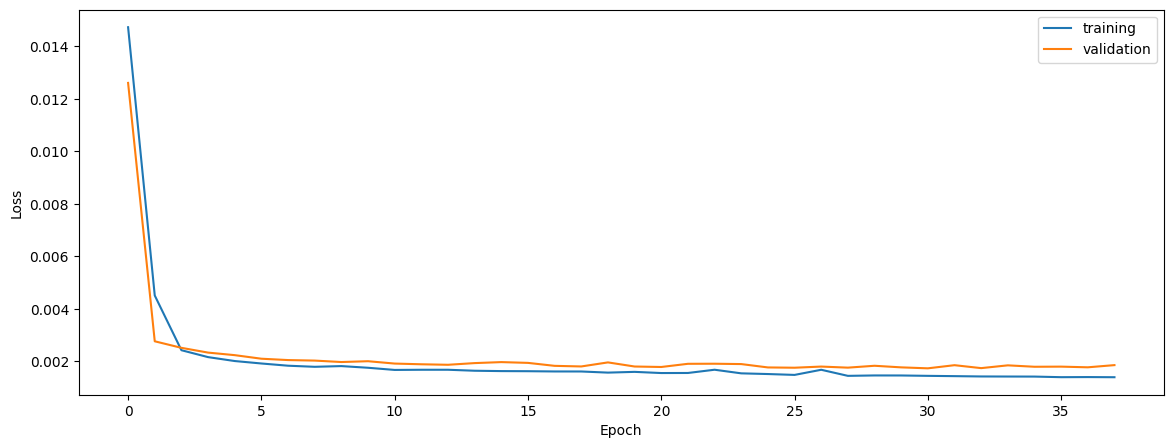

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9402244369649074
0.9384625188354369
0.9316122332570139


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9402244369649074
0.9384625188354369
0.9316122332570139


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.944095584515729
0.9416260092041984
0.9402899021557791


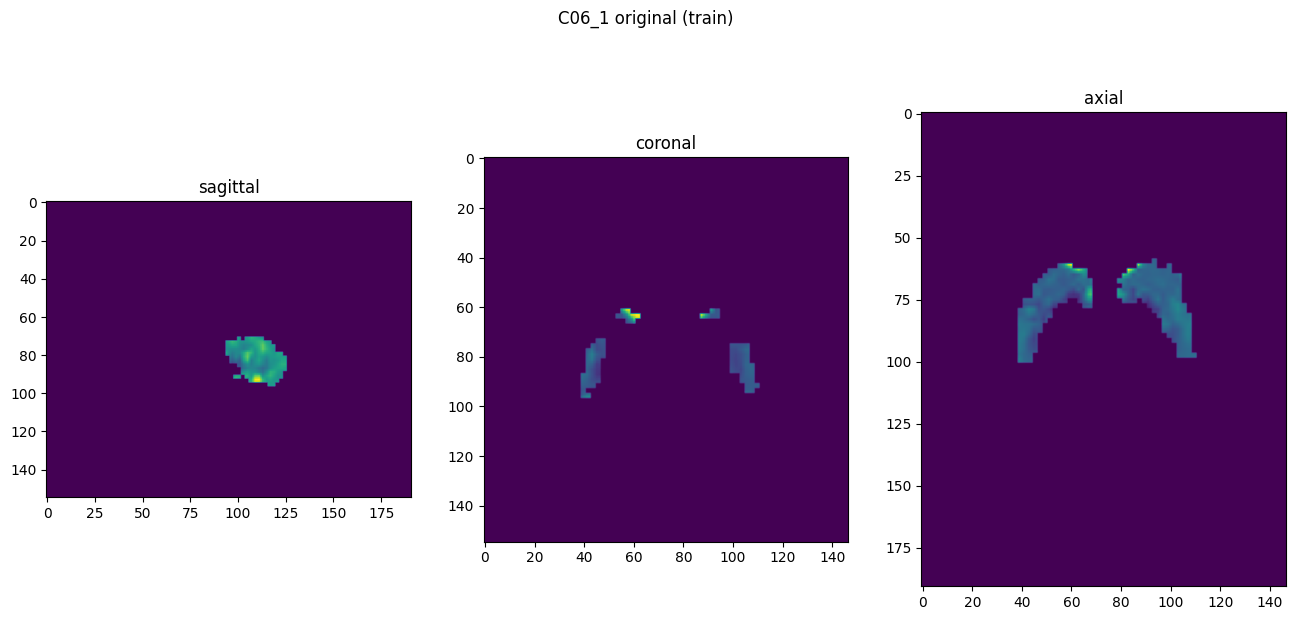

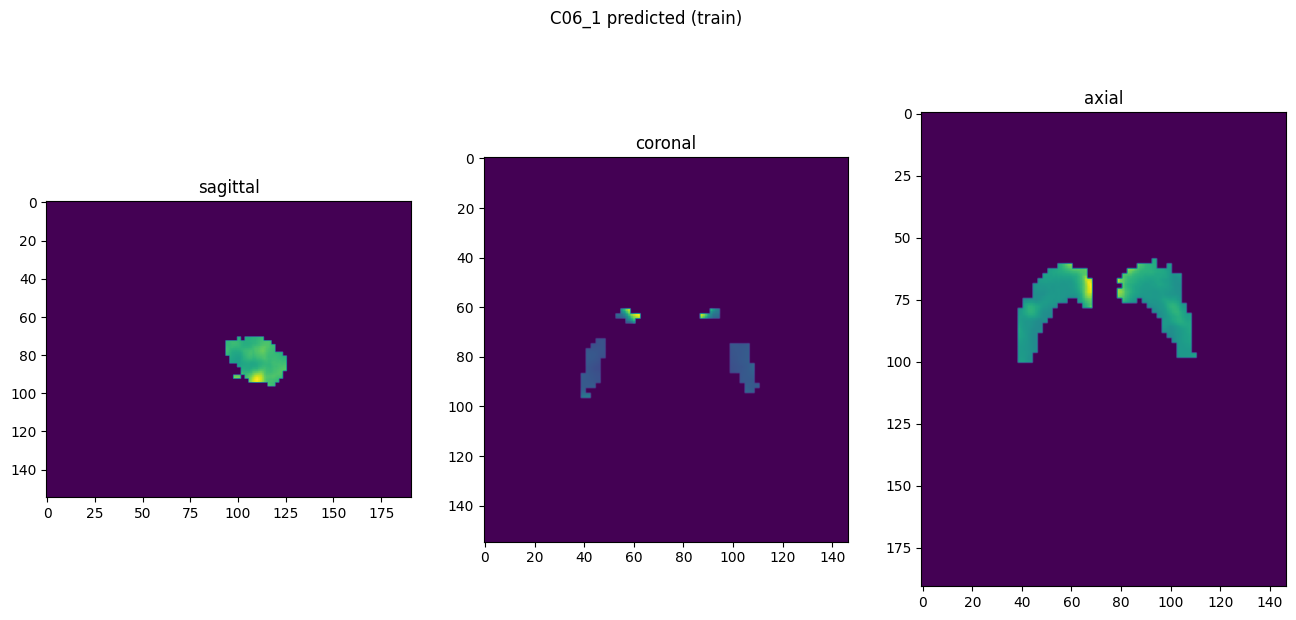

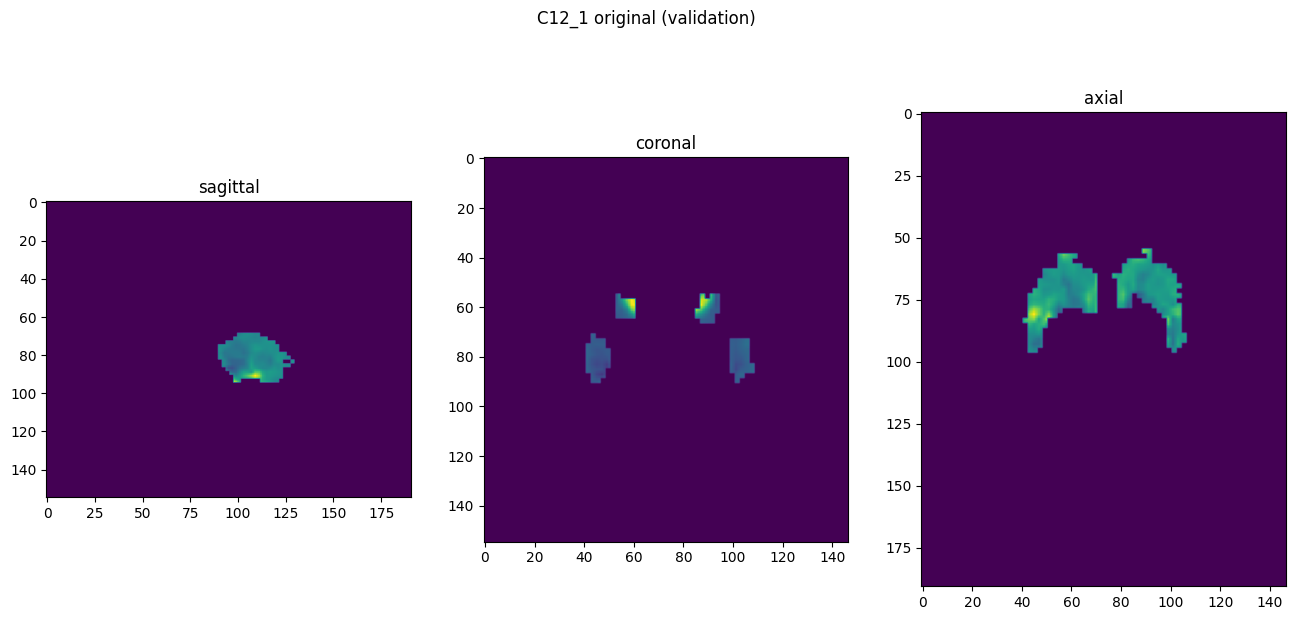

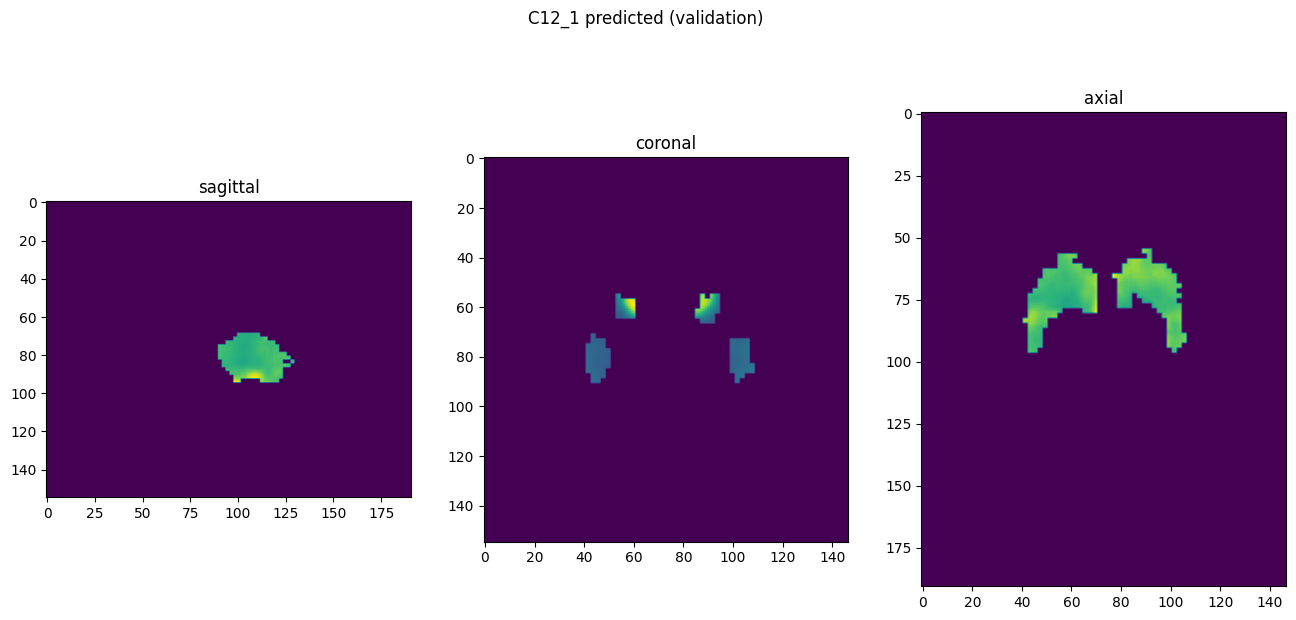

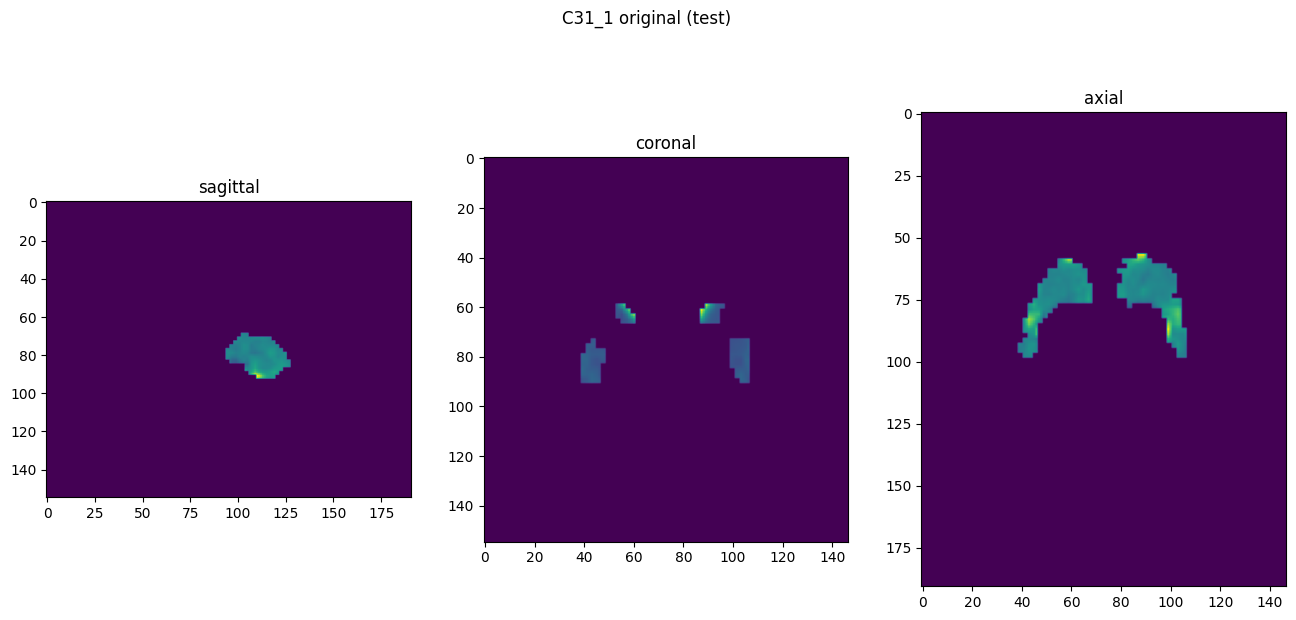

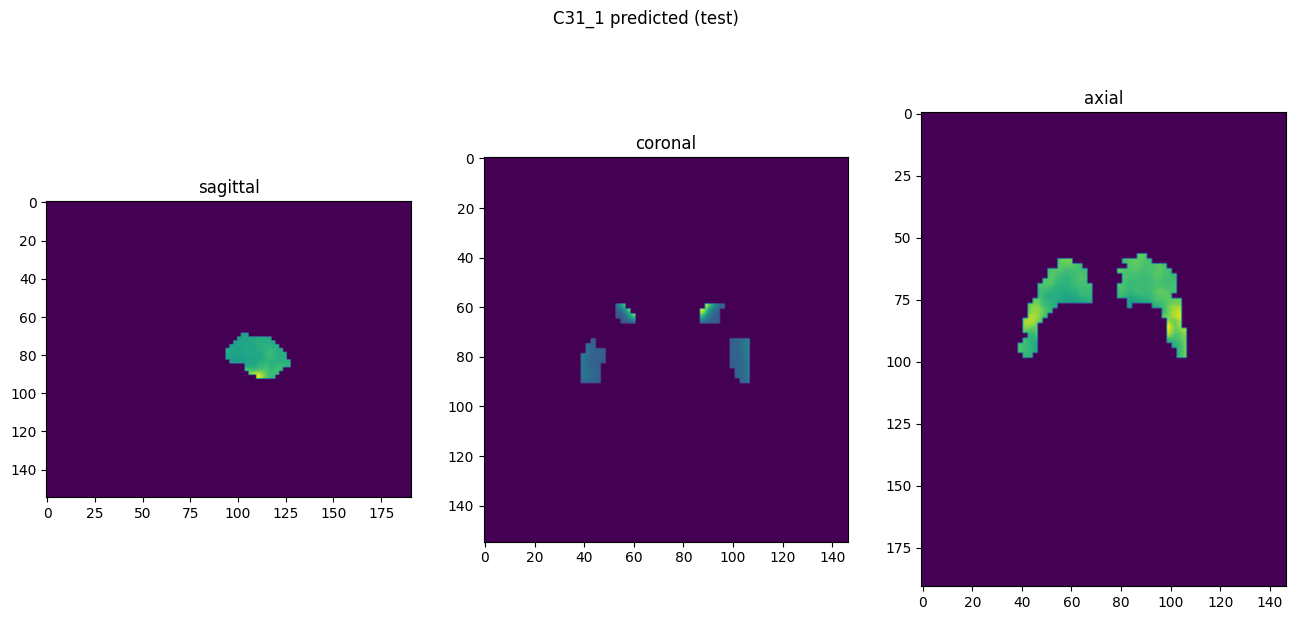

In [10]:
showResults(model, gen, threshold=None, background=False)